# Exploratory data analysis of the Strathcona County housing price

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from selenium import webdriver
from altair_saver import save
from vega_datasets import data

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from pandas_profiling import ProfileReport

In [2]:
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Summary of the data set

The data set used in this project is 2018 Property Tax Assessment from the Open Data portal of Strathcona County, Alberta. It is based on a property valuation date as of July 1, 2017 and property condition date as of December 31, 2017. Each row in the data set represents a property in Strathcona County, and each column represents an attribute of that property (e.g., building size, year built, does it have a fireplace, etc.). We are only interested in the residential subsets of  the original data set. There are 26,605 observations and 16 features in the training data set. Among these 16 features, there are 23 missing values in address, 8 missing values in year built,  8 missing values in building description. We plan to use Simple Imputer on missing values later on in prediction analysis.

## Import data and filter for residential properties

In [4]:
df = pd.read_csv("../data/2018_Property_Tax_Assessment.csv", skiprows = 1)
df = df.query("ASSESSCLAS == 'Residential'")
df.shape

(28450, 16)

### Property assessment value distribution

The property assessment value for single-family dwellings is right skewed. Most property assessment values are centered between $\$400,000$ and $\$500,000$, while almost no property is worth less than $\$300,000$, and there are a number of outlier properties worth more than $\$1,000,000$ and even up to $\$2,000,000$.

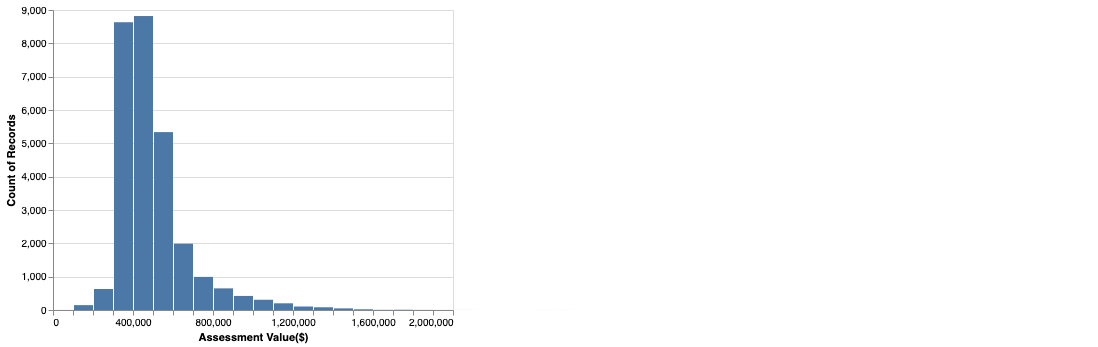

In [5]:
chart = alt.Chart(df).mark_bar().encode(
    alt.X('ASSESSMENT', bin=alt.Bin(maxbins=60), scale=alt.Scale(domain=(0,2000000)), title='Assessment Value($)'),
    alt.Y('count()'),
    tooltip='count()'
)
chart

## Partition the data set into training and test sets

Before processing the data, we split the data such that 90% of observations are in the training and 10% of observations are in the test set.

In [6]:
train_df, test_df = train_test_split(df, test_size = 0.10, random_state=123)
train_df.head()

,the_geom,TAX_YEAR,ROLL_NUM,ADDRESS,YEAR_BUILT,ASSESSCLAS,BLDG_DESC,BLDG_METRE,BLDG_FEET,GARAGE,FIREPLACE,BASEMENT,BSMTDEVL,ASSESSMENT,LATITUDE,LONGITUDE
7699,POINT (-113.27868410154399 53.52422473391141),2018,7204013002,23 NOTTINGHAM RD,1990.0,Residential,2 Storey & Basement,203,2189,Y,Y,Y,Y,505000,53.524152,-113.278945
34102,POINT (-113.28660933668657 53.559666067846145),2018,8181003005,10 ABERDEEN CR,2017.0,Residential,2 Storey & Basement,133,1433,Y,Y,Y,N,356000,53.559605,-113.286851
24119,POINT (-113.223672178728 53.48196513896649),2018,2207103009,265 52152 RNG RD 225,1979.0,Residential,2 Storey & Basement,192,2067,Y,Y,Y,Y,571000,53.482807,-113.224167
4829,POINT (-113.25723973453104 53.542257139037815),2018,8001039000,36 DEWBERRY PL,1989.0,Residential,Split Level & Crawl Space,125,1342,Y,Y,Y,Y,410000,53.542325,-113.257504
12129,POINT (-113.27062226263668 53.53298593959325),2018,7281074103,165 COURTENAY DR,1998.0,Residential,2 Storey & Basement,204,2194,Y,Y,Y,Y,519000,53.532916,-113.270911


In [7]:
train_df.shape

(25605, 16)

In [8]:
X_train = train_df.drop(columns=['ASSESSMENT'])
y_train = train_df['ASSESSMENT']

X_test = test_df.drop(columns=['ASSESSMENT'])
y_test = test_df['ASSESSMENT']

## Exploratory data analysis (EDA) on the training data set

In [9]:
train_df.describe()

,TAX_YEAR,ROLL_NUM,YEAR_BUILT,BLDG_METRE,BLDG_FEET,ASSESSMENT,LATITUDE,LONGITUDE
count,25605.0,2.560500e+04,25597.000000,25605.000000,25605.000000,2.560500e+04,25605.000000,25605.000000
mean,2018.0,6.095382e+09,1988.663398,156.877836,1688.720328,4.961323e+05,53.525498,-113.244651
std,0.0,2.417761e+09,16.522669,58.341542,627.915539,1.927636e+05,0.040672,0.084889
min,2018.0,1.002702e+09,1900.000000,9.000000,100.000000,2.900000e+04,53.366914,-113.344318
25%,2018.0,3.215714e+09,1973.000000,114.000000,1228.000000,3.790000e+05,53.515648,-113.289593
50%,2018.0,7.160092e+09,1991.000000,141.000000,1519.000000,4.500000e+05,53.529335,-113.269052
75%,2018.0,8.007022e+09,2003.000000,188.000000,2024.000000,5.450000e+05,53.547183,-113.250371
max,2018.0,9.503053e+09,2018.000000,954.000000,10270.000000,5.182000e+06,53.858663,-112.846514


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25605 entries, 7699 to 23031
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   the_geom    25605 non-null  object 
 1   TAX_YEAR    25605 non-null  int64  
 2   ROLL_NUM    25605 non-null  int64  
 3   ADDRESS     25582 non-null  object 
 4   YEAR_BUILT  25597 non-null  float64
 5   ASSESSCLAS  25605 non-null  object 
 6   BLDG_DESC   25597 non-null  object 
 7   BLDG_METRE  25605 non-null  int64  
 8   BLDG_FEET   25605 non-null  int64  
 9   GARAGE      25605 non-null  object 
 10  FIREPLACE   25605 non-null  object 
 11  BASEMENT    25605 non-null  object 
 12  BSMTDEVL    25605 non-null  object 
 13  ASSESSMENT  25605 non-null  int64  
 14  LATITUDE    25605 non-null  float64
 15  LONGITUDE   25605 non-null  float64
dtypes: float64(3), int64(5), object(8)
memory usage: 3.3+ MB


### `pandas_profiler`

In [11]:
from pandas_profiling import ProfileReport

profile = ProfileReport(train_df, title='Pandas Profiling Report', minimal=True)
profile.to_notebook_iframe()

### Examine correlations of relevant features with the target

The correlation heat map for our numeric features shows that the assessment value has its strongest correlation with the square footage attribute of the property. The second most correlated feature to the assessment value is the year built. It makes sense that for larger properties and newer properties the larger the assessment value.

In [12]:
df_cor = df.drop(columns=['TAX_YEAR', 'ROLL_NUM', 'BLDG_METRE'])

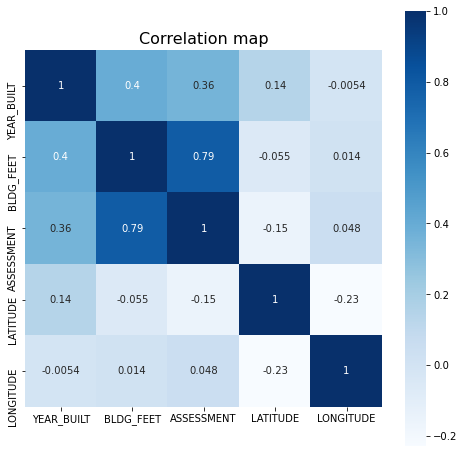

In [13]:
corrmat = df_cor.corr(method='pearson')
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, vmax=1., square=True, annot=True, cmap=plt.cm.Blues)
plt.title("Correlation map", fontsize=16)
plt.show()

### Identify numeric, categorical, binary, and other features

In [14]:
numeric_features=['YEAR_BUILT', 'BLDG_FEET', 'LATITUDE','LONGITUDE']

In [15]:
categorical_features=['BLDF_DESC']

In [16]:
binary_features=['GARAGE', 'FIREPLACE', 'BASEMENT', 'BASEMENTDVL']

In [17]:
drop_features=['the_geom', 'TAX_YEAR', 'ROLL_NUM', 'ASSESSCLAS', 'ADDRESS', 'BLDG_METRE']

In [18]:
target = 'ASSESSMENT'

### Relationship between building sizes and assessed values

This graph shows the property assessment values and building sizes (in square feet) for each property (in grey), along with the expected property assessment value for a given building size (in blue). We can see that as building size increases, the expected property assessment value rises as well.

In [19]:
df_bsav = train_df.groupby('BLDG_FEET').mean('ASSESSMENT')
df_bsav = df_bsav.reset_index()

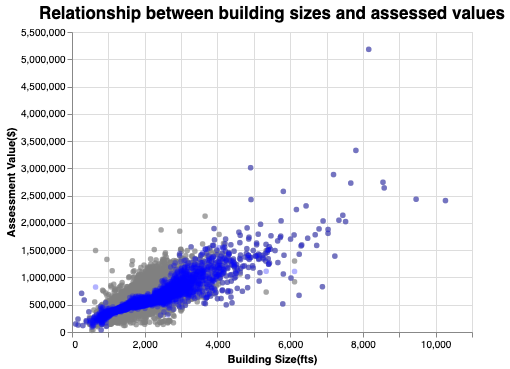

In [20]:
alt.data_transformers.disable_max_rows()
population = alt.Chart(train_df, title = "Relationship between building sizes and assessed values").mark_circle(color='grey').encode(
    alt.X('BLDG_FEET', title = "Building Size(fts)"),
    alt.Y('ASSESSMENT', title = "Assessment Value($)"))

conditional = alt.Chart(df_bsav).mark_circle(opacity=0.3, color='blue').encode(
    alt.X('BLDG_FEET', title = "Building Size(fts)"),
    alt.Y('ASSESSMENT', title = "Assessment Value($)"))

(population + conditional).configure_title(fontSize=17) 

### Violin Plots of binary features  

To look at whether the binary feature predictors might be useful in predicting the assessment value of a residential property, we plotted a violin plot for each of the binary features with color code orange representing “Yes’ and blue representing “No”. The binary features include garage, fireplace, basement, and basement development. Observing the plot, we can see that on average, having each feature correlates with a higher assessment value relative to not having the feature. In addition, having a garage, fireplace, or basement also indicates the possibility of higher assessment values, whereas assessment values seem capped below $\$1,000,000$ for not having these features. 

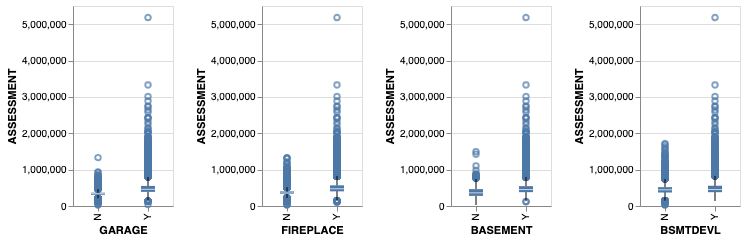

In [21]:
boxplot = (alt.Chart(train_df).mark_boxplot().encode(
    x=alt.X(alt.repeat(), type='nominal'),
    y='ASSESSMENT'
).properties(height=200, width=100
).repeat(['GARAGE', 'FIREPLACE', 'BASEMENT', 'BSMTDEVL']
))
boxplot

In [22]:
import altair as alt
from vega_datasets import data

garage =(alt.Chart(train_df).transform_density(
    'ASSESSMENT',
    as_=['ASSESSMENT', 'density'],
    extent=[0, 1_600_000],
    groupby=['GARAGE']
).mark_area(orient='horizontal').encode(
    y=alt.Y('ASSESSMENT:Q'),
    color=alt.Color('GARAGE:N',legend=None),
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'GARAGE:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=100
))

In [23]:
fireplace = (alt.Chart(train_df).transform_density(
    'ASSESSMENT',
    as_=['ASSESSMENT', 'density'],
    extent=[0, 1_600_000],
    groupby=['FIREPLACE']
).mark_area(orient='horizontal').encode(
    y=alt.Y('ASSESSMENT:Q', title=''),
    color=alt.Color('FIREPLACE:N',legend=None),
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'FIREPLACE:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=100
))

In [24]:
basement = (alt.Chart(train_df).transform_density(
    'ASSESSMENT',
    as_=['ASSESSMENT', 'density'],
    extent=[0, 1_600_000],
    groupby=['BASEMENT']
).mark_area(orient='horizontal').encode(
    y=alt.Y('ASSESSMENT:Q', title=''),
    color=alt.Color('BASEMENT:N',legend=None),
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'BASEMENT:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=100
))

In [25]:
basementdevl = (alt.Chart(train_df).transform_density(
    'ASSESSMENT',
    as_=['ASSESSMENT', 'density'],
    extent=[0, 1_600_000],
    groupby=['BSMTDEVL']
).mark_area(orient='horizontal').encode(
    y=alt.Y('ASSESSMENT:Q', title=''),
    color=alt.Color('BSMTDEVL:N',legend=None),
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'BSMTDEVL:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=100
))

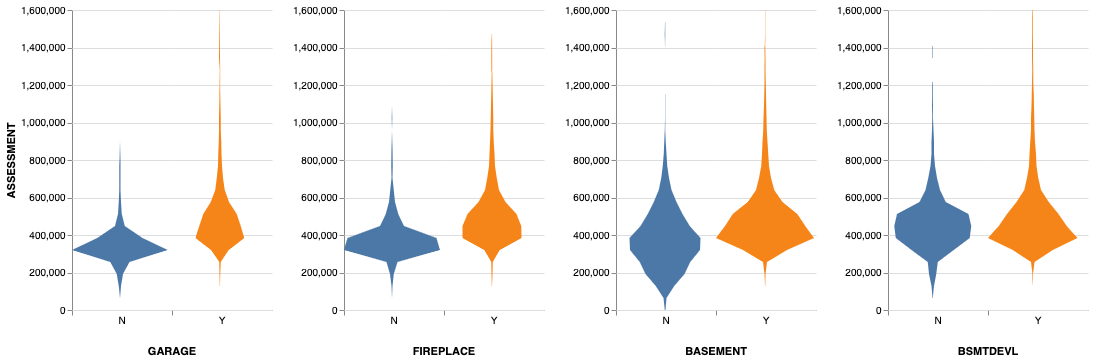

In [26]:
violinplot = alt.hconcat(garage, fireplace, basement, basementdevl).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)
violinplot

In [27]:
customized_ls = ['GARAGE', 'FIREPLACE', 'BASEMENT', 'BSMTDEVL']

def plot(feature):
    plot = (alt.Chart(train_df).transform_density(
        'ASSESSMENT',
        as_=['ASSESSMENT', 'density'],
        extent=[0, 1_600_000],
        groupby=[feature]
    ).mark_area(orient='horizontal').encode(
        y=alt.Y('ASSESSMENT:Q'),
        color=alt.Color(feature,legend=None),
        x=alt.X(
            'density:Q',
            stack='center',
            impute=None,
            title=None,
            axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
        ),
        column=alt.Column(
            feature,
            header=alt.Header(
                titleOrient='bottom',
                labelOrient='bottom',
                labelPadding=0,
            ),
        )
    ).properties(
        width=100
    ))
    return plot

In [28]:
plot_1 = plot('GARAGE')
plot_2 = plot('FIREPLACE')
plot_3 = plot('BASEMENT')
plot_4 = plot('BSMTDEVL')

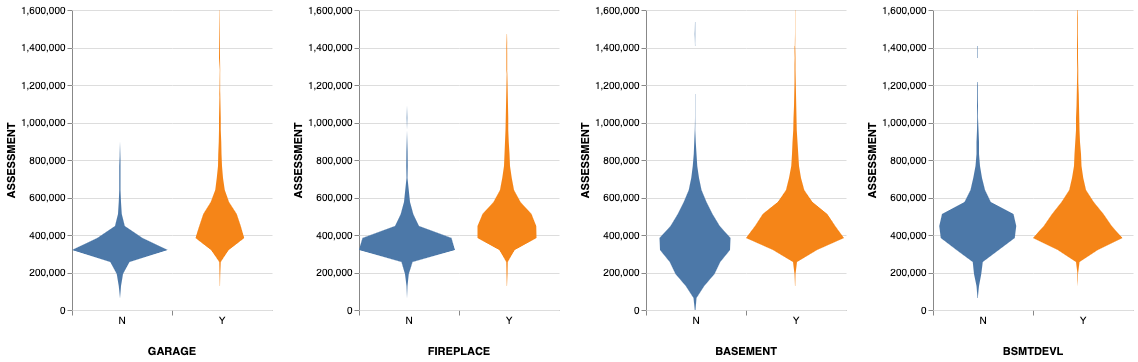

In [29]:
alt.hconcat(plot_1, plot_2, plot_3, plot_4).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

## References

“2018 Property Tax Assessment”. Strathcona County’s Open Data Portal. <https://data.strathcona.ca/Housing-Buildings/2018-Property-Tax-Assessment/6wvk-j7e9>